In [2]:
#Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random

#visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import wget

#tf libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing
# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

In [6]:
#helper function
url =  'https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py'

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

In [7]:
spices_data = 'D:\Spices_Clasification_update'
walk_through_dir(spices_data)

There are 25 directories and 0 images in 'D:\Spices_Clasification_update'.
There are 0 directories and 200 images in 'D:\Spices_Clasification_update\adas'.
There are 0 directories and 195 images in 'D:\Spices_Clasification_update\andaliman'.
There are 0 directories and 201 images in 'D:\Spices_Clasification_update\asam_jawa'.
There are 0 directories and 200 images in 'D:\Spices_Clasification_update\biji_ketumbar'.
There are 0 directories and 200 images in 'D:\Spices_Clasification_update\bunga_lawang'.
There are 0 directories and 202 images in 'D:\Spices_Clasification_update\cengkeh'.
There are 0 directories and 215 images in 'D:\Spices_Clasification_update\daun_ketumbar'.
There are 0 directories and 206 images in 'D:\Spices_Clasification_update\daun_salam'.
There are 0 directories and 206 images in 'D:\Spices_Clasification_update\jahe'.
There are 0 directories and 190 images in 'D:\Spices_Clasification_update\jinten'.
There are 0 directories and 192 images in 'D:\Spices_Clasification_u

In [8]:
img_directory = Path(spices_data)
filepaths = list(img_directory.glob(r'**/*.JPG')) + list(img_directory.glob(r'**/*.jpg')) + list(img_directory.glob(r'**/*.png')) + list(img_directory.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [9]:
image_df

Filepath        Label
0       D:\Spices_Clasification_update\adas\adas-001.jpg         adas
1       D:\Spices_Clasification_update\adas\adas-002.jpg         adas
2       D:\Spices_Clasification_update\adas\adas-003.jpg         adas
3       D:\Spices_Clasification_update\adas\adas-004.jpg         adas
4       D:\Spices_Clasification_update\adas\adas-005.jpg         adas
...                                                  ...          ...
10013  D:\Spices_Clasification_update\kayu manis\Imag...   kayu manis
10014  D:\Spices_Clasification_update\kayu secang\Ima...  kayu secang
10015  D:\Spices_Clasification_update\kayu secang\Ima...  kayu secang
10016  D:\Spices_Clasification_update\kemiri\Image_1.png       kemiri
10017  D:\Spices_Clasification_update\kemiri\Image_2.png       kemiri

[10018 rows x 2 columns]

**VISUALIZE THE DATASET**

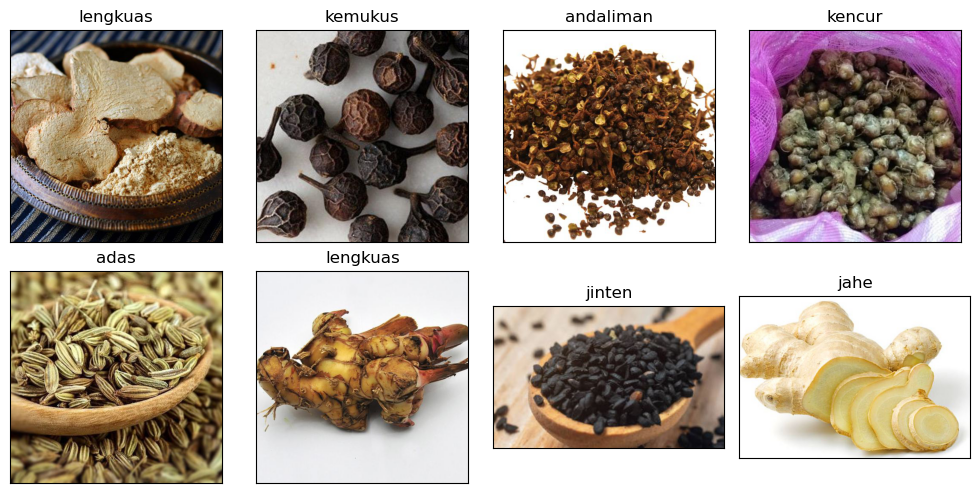

In [10]:
# Display 8 pictures of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 8)

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 5),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img = plt.imread(image_df['Filepath'].iloc[random_index[i]])
    ax.imshow(img)
    ax.set_title(image_df['Label'].iloc[random_index[i]])

plt.tight_layout()
plt.show()

In [11]:
#separate to training, validation, testing
training_dataset, testing_dataset = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=1)

In [12]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input
)

In [13]:
training_images = train_generator.flow_from_dataframe(
dataframe = training_dataset,
x_col='Filepath',
y_col = 'Label',
target_size=(224,224),
color_mode='rgb',
class_mode='categorical',
batch_size=32,
shuffle=True,
seed=42,
subset='training')

validation_images = train_generator.flow_from_dataframe(
dataframe = training_dataset,
x_col='Filepath',
y_col = 'Label',
target_size=(224,224),
color_mode='rgb',
class_mode='categorical',
batch_size=32,
shuffle=True,
seed=42,
subset='validation')

test_images = test_generator.flow_from_dataframe(
dataframe = testing_dataset,
x_col='Filepath',
y_col = 'Label',
target_size=(224,224),
color_mode='rgb',
class_mode='categorical',
batch_size=32,
shuffle=False)

Found 6412 validated image filenames belonging to 25 classes.
Found 1602 validated image filenames belonging to 25 classes.
Found 2004 validated image filenames belonging to 25 classes.


In [14]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(224,224),
    layers.experimental.preprocessing.Rescaling(1./255),
])

augmented = keras.Sequential([
    preprocessing.RandomFlip("horizontal_and_vertical"),
    preprocessing.RandomZoom(0.5),
    preprocessing.RandomRotation(0.5),
    preprocessing.RandomWidth(0.5),
    preprocessing.RandomHeight(0.5),
    tf.keras.layers.RandomContrast(factor=0.4),
    tf.keras.layers.RandomBrightness(0.4),
], name="data_augmentation")

In [15]:
input_shape = (224,224,3)

Base_Model = tf.keras.applications.MobileNetV3Large(
input_shape=input_shape,
include_top = False,
    weights = 'imagenet',
    pooling='avg'
)
Base_Model.trainable = False


12683000/12683000 [==============================] - 11s 1us/step


In [16]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 5 epochs
early_stopping = EarlyStopping(monitor="val_accuracy", # watch the val loss metric
                                                  patience=10,
                                                  restore_best_weights=True) # if val loss decreases for 3 epochs in a row, stop training

In [17]:
checkpoint_path = "spices classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [21]:
def build_model(base_model, num_classes):
    input = base_model.input
    x = resize_and_rescale(input)
    x = augmented(x)
    x = Dense(256,activation='relu')(base_model.output)
    x = Dense(128, activation='relu')(x)
    BatchNormalization()
    x = Dropout(0.5)(x)
    x = Dense(64, activation = 'relu')(x)
    x = Dense(32, activation = 'relu')(x)
    BatchNormalization()
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes,activation='softmax')(x)
    model = Model(inputs=input, outputs=outputs)
    return model

model = build_model(Base_Model,25)
model.compile(
optimizer = Adam(0.0001),
loss='categorical_crossentropy',
metrics=['accuracy'])



In [22]:
history = model.fit(
    training_images,
    steps_per_epoch=len(training_images),
    validation_data=validation_images,
    validation_steps=len(validation_images),
    epochs=100,
     callbacks=[early_stopping, checkpoint_callback]
)

Epoch 1/100
201/201 [==============================] - 191s 928ms/step - loss: 3.2467 - accuracy: 0.0674 - val_loss: 3.0388 - val_accuracy: 0.2534
Epoch 2/100
201/201 [==============================] - 118s 590ms/step - loss: 2.9816 - accuracy: 0.1263 - val_loss: 2.6113 - val_accuracy: 0.5250
Epoch 3/100
201/201 [==============================] - 135s 674ms/step - loss: 2.6867 - accuracy: 0.2051 - val_loss: 2.0941 - val_accuracy: 0.6361
Epoch 4/100
201/201 [==============================] - 120s 598ms/step - loss: 2.3902 - accuracy: 0.2891 - val_loss: 1.6720 - val_accuracy: 0.6798
Epoch 5/100
201/201 [==============================] - 117s 582ms/step - loss: 2.1429 - accuracy: 0.3484 - val_loss: 1.3774 - val_accuracy: 0.7353
Epoch 6/100
201/201 [==============================] - 121s 600ms/step - loss: 1.9421 - accuracy: 0.4113 - val_loss: 1.1242 - val_accuracy: 0.7722
Epoch 7/100
201/201 [==============================] - 123s 610ms/step - loss: 1.7530 - accuracy: 0.4599 - val_loss: 0

201/201 [==============================] - 109s 542ms/step - loss: 0.3049 - accuracy: 0.8941 - val_loss: 0.1862 - val_accuracy: 0.9557
Epoch 57/100
201/201 [==============================] - 108s 537ms/step - loss: 0.2923 - accuracy: 0.8938 - val_loss: 0.1859 - val_accuracy: 0.9544
Epoch 58/100
201/201 [==============================] - 109s 544ms/step - loss: 0.2849 - accuracy: 0.8999 - val_loss: 0.1873 - val_accuracy: 0.9613
Epoch 59/100
201/201 [==============================] - 108s 535ms/step - loss: 0.3022 - accuracy: 0.8955 - val_loss: 0.1842 - val_accuracy: 0.9557
Epoch 60/100
201/201 [==============================] - 108s 539ms/step - loss: 0.2713 - accuracy: 0.9047 - val_loss: 0.1833 - val_accuracy: 0.9594
Epoch 61/100
201/201 [==============================] - 108s 536ms/step - loss: 0.2728 - accuracy: 0.9049 - val_loss: 0.1902 - val_accuracy: 0.9582
Epoch 62/100
201/201 [==============================] - 109s 543ms/step - loss: 0.2559 - accuracy: 0.9053 - val_loss: 0.1919 

In [23]:
results = model.evaluate(test_images, verbose=2)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

63/63 - 30s - loss: 0.1386 - accuracy: 0.9666 - 30s/epoch - 476ms/step
    Test Loss: 0.13861
Test Accuracy: 96.66%


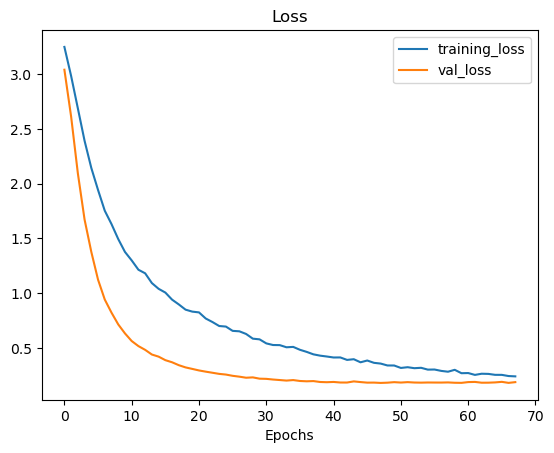

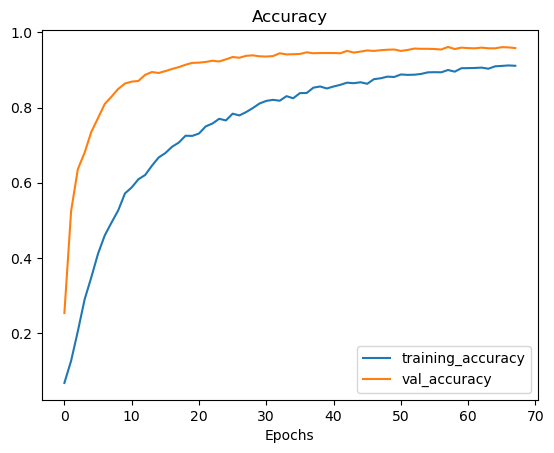

In [24]:
plot_loss_curves(history)

In [25]:
model.save('train_model_mobileNetV3.h5')

C:\Users\ekaad\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [29]:
 converter = tf.lite.TFLiteConverter.from_keras_model(model)
 tflite_model = converter.convert()

 with open('model.tflite_2', 'wb') as f:
   f.write(tflite_model)

In [26]:
history.history #Return Dictionary of history

{'loss': [3.2466838359832764,
  2.981621265411377,
  2.6866724491119385,
  2.39015531539917,
  2.1429190635681152,
  1.9420523643493652,
  1.7529767751693726,
  1.631117820739746,
  1.4947396516799927,
  1.3771510124206543,
  1.2998864650726318,
  1.2147774696350098,
  1.1822987794876099,
  1.0931533575057983,
  1.0408731698989868,
  1.006682276725769,
  0.942137598991394,
  0.8985234498977661,
  0.8509296774864197,
  0.8329789638519287,
  0.8258073329925537,
  0.7701758146286011,
  0.7379922270774841,
  0.7016632556915283,
  0.6965627670288086,
  0.6574123501777649,
  0.6533403992652893,
  0.6291337013244629,
  0.5863028168678284,
  0.5800406336784363,
  0.5432596802711487,
  0.5284007787704468,
  0.5273900628089905,
  0.5077767968177795,
  0.5112001895904541,
  0.48483967781066895,
  0.4657381772994995,
  0.4433203935623169,
  0.431388795375824,
  0.42348578572273254,
  0.4145926237106323,
  0.41510939598083496,
  0.3925727307796478,
  0.3988860249519348,
  0.37082672119140625,
  0.3

In [27]:
#Recording History in json
import json
with open('train_hist_mobileNetV3.json','w') as f:
  json.dump(history.history,f)

In [28]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [29]:
print("Validation set Accuracy: {} %".format(history.history['val_accuracy'][-1]*100))

Validation set Accuracy: 95.81772685050964 %


In [30]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (training_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

63/63 [==============================] - 27s 411ms/step
The first 5 predictions: ['kemukus', 'vanili', 'kluwek', 'daun_salam', 'lada']


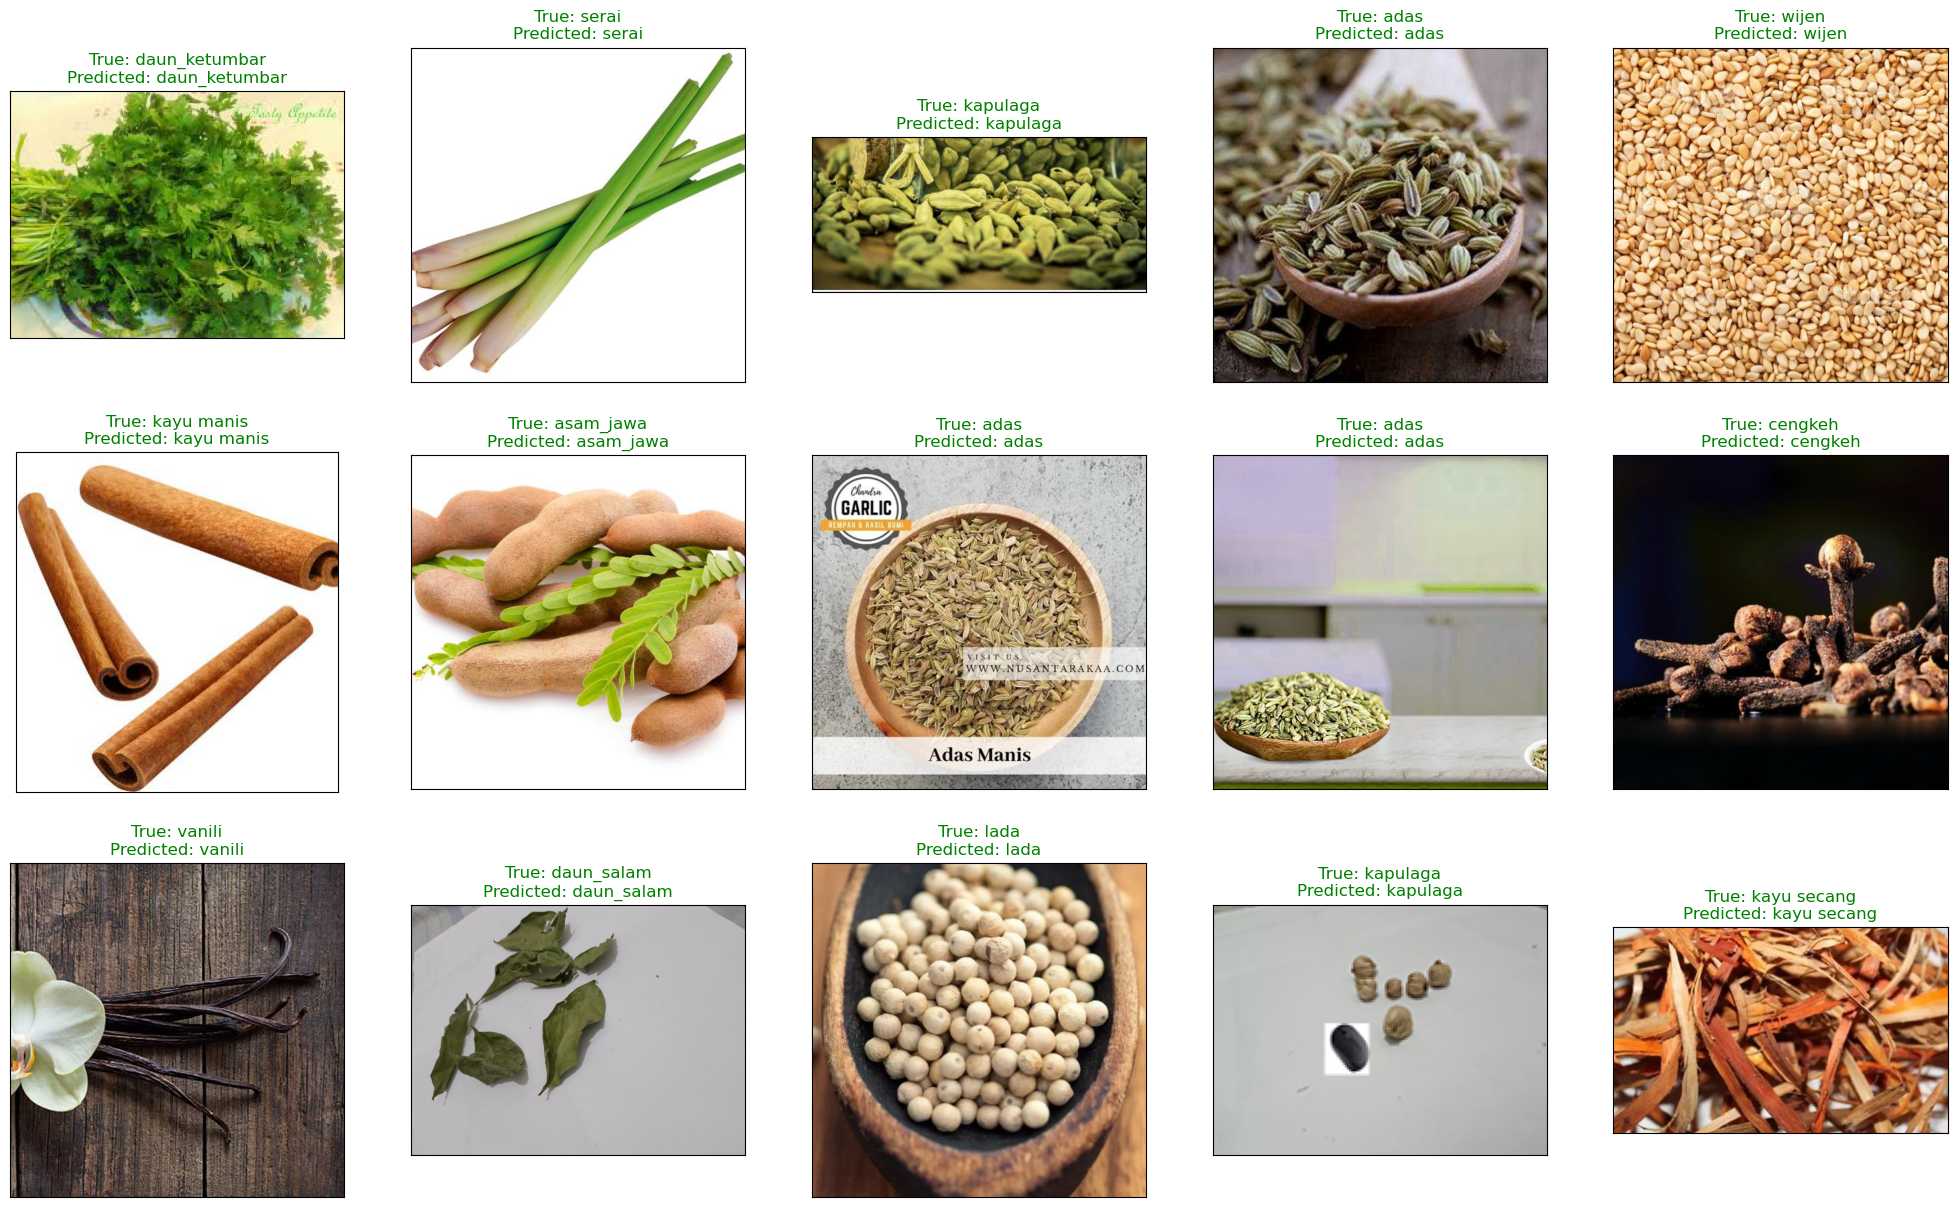

<Figure size 640x480 with 0 Axes>

In [31]:
  # Display 15 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(testing_dataset) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(testing_dataset.Filepath.iloc[random_index[i]]))
    if testing_dataset.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {testing_dataset.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [32]:
y_test = list(testing_dataset.Label)
print(classification_report(y_test, pred))

               precision    recall  f1-score   support

         adas       0.99      0.94      0.96        84
    andaliman       0.95      0.99      0.97        88
    asam_jawa       0.97      0.99      0.98        77
biji_ketumbar       0.96      0.88      0.91        73
 bunga_lawang       0.99      1.00      0.99        82
      cengkeh       1.00      0.94      0.97        93
daun_ketumbar       0.99      1.00      0.99        79
   daun_salam       0.92      0.91      0.92        92
         jahe       1.00      0.97      0.99        74
       jinten       0.92      0.99      0.95        82
     kapulaga       0.88      0.97      0.92        74
   kayu manis       0.94      0.91      0.92        81
  kayu secang       1.00      0.96      0.98        69
       kemiri       0.93      0.85      0.89        80
      kemukus       0.99      1.00      0.99        82
       kencur       1.00      0.93      0.96        86
       kluwek       1.00      0.97      0.99        79
       ku

In [ ]:
#Convert to TF LITE
import tensorflow as tf
import pathlib

model = tf.keras.models.load_model('train_model_mobileNetV3.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Specify a file name for the TFLite model
tflite_model_file = pathlib.Path('D:\Indonesian_Spices\model_mobileNetV3.tflite')

# Save the TFLite model to a file
tflite_model_file.write_bytes(tflite_model)
